In [186]:
import numpy as np
import scipy.optimize
import scipy.stats
import cvxpy as cp
from matplotlib import pyplot as plt
from concurrent.futures import ThreadPoolExecutor


# Large scale linear programming

- [Efficient Algorithms for Global Inference in Internet Marketplaces](https://arxiv.org/pdf/2103.05277.pdf)
- [ECLIPSE: An Extreme-Scale Linear Program Solver for Web-Applications](http://proceedings.mlr.press/v119/basu20a/basu20a.pdf)
- [Appendix: Supplemental Material for “ECLIPSE: An Extreme-Scale Linear
Program Solver for Web-Applications"](http://proceedings.mlr.press/v119/basu20a/basu20a-supp.pdf)

$$\max_{x \in C} \{c^Tx + \frac{\gamma}{2}x^Tx\},\ s.t. Ax <= b$$

$$g_\gamma(\lambda) = \inf_{x \in C}\{ c^Tx + \frac{\gamma}{2}x^Tx + \lambda^T(Ax - b)\}$$

$$x(\lambda) = \prod_{C}(A^T\lambda + c)$$

$$\nabla g_\gamma(\lambda) = Ax(\lambda) + b$$

$$\lambda^{k+1} = (\lambda^k + \eta \nabla g_\gamma(\lambda^k)_+$$

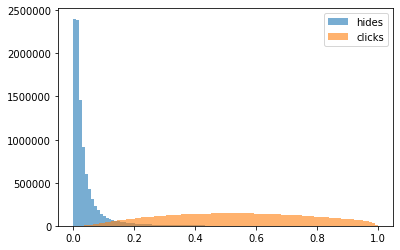

In [260]:
n_users = 1000000
n_blocks = 10

click_probas = scipy.stats.norm(0, 1).rvs((n_users, n_blocks))
click_probas[:, 3] += 2
click_probas = scipy.special.expit(click_probas)

hide_probas = scipy.stats.norm(-4, 1).rvs((n_users, n_blocks))
hide_probas[:, 4] += 2
hide_probas = scipy.special.expit(hide_probas)

max_clicks = click_probas.sum(axis=0)

plt.hist(hide_probas.ravel(), label='hides', bins=100, alpha=0.6)
plt.hist(click_probas.ravel(), label='clicks', bins=100, alpha=0.6)
plt.legend()

## Simplex projection

[Статья с алгоритмом](https://dl.acm.org/doi/10.1145/1390156.1390191)

In [270]:
%%time

def simplex_projection(w):
    w_sorted = np.flip(np.sort(w, axis=1), axis=1)
    w_cumsum = np.cumsum(w_sorted, axis=1) - 1
    t = w_sorted - w_cumsum / (np.arange(w.shape[1]) + 1).reshape(1, -1)
    t[t <= 0] = np.inf
    rho = np.argmin(t, axis=1)
    theta = w_cumsum[np.arange(w.shape[0]), rho] / (rho + 1)
    y = w - theta.reshape(-1, 1)
    y[y < 0] = 0

    assert y.shape == w.shape
    assert np.allclose(y.sum(axis=1), 1)
    assert np.all(y >= 0)

    return y

def fast_simplex_projection(w, workers=16):
    block = (w.shape[0] // (workers * 5))

    with ThreadPoolExecutor(max_workers=workers) as pool:
        result2 = pool.map(simplex_projection, [w[i:i+block] for i in range(0, w.shape[0], block)])
        result2 = np.vstack(list(result2))
    return result2

CPU times: user 11 µs, sys: 7 µs, total: 18 µs
Wall time: 21.9 µs


In [264]:
%%time
result1 = simplex_projection(click_probas)

CPU times: user 420 ms, sys: 127 ms, total: 547 ms
Wall time: 549 ms


In [265]:
%%time
result2 = fast_simplex_projection(click_probas)

assert np.alltrue(result2 == result1)

CPU times: user 553 ms, sys: 175 ms, total: 729 ms
Wall time: 237 ms


In [266]:
%%time

test_show_proba = np.ones_like(click_probas)
test_min_clicks = max_clicks * 0.01
test_max_hides = np.sum(np.min(hide_probas, axis=1)) * 0.8

test_lambd = np.ones(click_probas.shape[1] + 1)

def A_dot_x(click_probas, hide_probas, show_proba):
    return np.hstack((-np.sum(show_proba * click_probas, axis=0), np.sum(show_proba * hide_probas)))
assert A_dot_x(click_probas, hide_probas, test_show_proba).shape == test_lambd.shape

def At_dot_lambda(clicks_probas, hide_probas, lambd):
    return -clicks_probas * lambd[:-1] + hide_probas * lambd[-1]
assert At_dot_lambda(click_probas, hide_probas, test_lambd).shape == click_probas.shape

def At_dot_lambda_p_c(click_probas, hide_probas, lambd):
    return At_dot_lambda(click_probas, hide_probas, lambd) - click_probas
assert At_dot_lambda_p_c(click_probas, hide_probas, test_lambd).shape == click_probas.shape

def x_lambda(click_probas, hide_probas, lambd, gamma):
    return fast_simplex_projection(At_dot_lambda_p_c(click_probas, hide_probas, lambd) * -1. / gamma)
assert x_lambda(click_probas, hide_probas, test_lambd, gamma=1).shape == click_probas.shape


def grad_g(click_probas, hide_probas, lambd, min_clicks, max_hides, gamma):
    assert click_probas.shape == hide_probas.shape
    assert lambd.shape[0] == click_probas.shape[1] + 1
    
    show_proba = x_lambda(click_probas, hide_probas, lambd, gamma)
    grad = A_dot_x(click_probas, hide_probas, show_proba) 
    
    grad[:-1] += min_clicks
    grad[-1] = grad[-1] - max_hides

    target = -np.sum(click_probas * show_proba) + gamma / 2 * np.sum(show_proba * show_proba)

    g = target + lambd.dot(grad)
    return g, grad, target

assert grad_g(click_probas, hide_probas, test_lambd, test_min_clicks, test_max_hides, 1)[1].shape == test_lambd.shape



CPU times: user 1.72 s, sys: 377 ms, total: 2.1 s
Wall time: 1.02 s


In [280]:
%%time
gamma = 1e-2
scipy.optimize.check_grad(lambda x: grad_g(click_probas, hide_probas, x, test_min_clicks, test_max_hides, gamma)[0],
                          lambda x: grad_g(click_probas, hide_probas, x, test_min_clicks, test_max_hides, gamma)[1],
                          test_lambd)

CPU times: user 9.44 s, sys: 2.7 s, total: 12.1 s
Wall time: 6.37 s


0.7424460776972988

# Backtracking + оценка константы липшеца

In [296]:
def eclipse(click_probas, hide_probas, min_clicks, max_hides, gamma=1e-1, verbose=True):

    lambd = np.ones(click_probas.shape[1] + 1)

    target_history = []
    dual_history = []

    grad_old, lambd_old = None, None
    hist = []

    g, grad, _ = grad_g(click_probas, hide_probas, lambd, min_clicks, max_hides, gamma)

    for i in range(200):    
        if len(hist) > 0:
            eta = 1 / (np.max(hist))
        else:
            # Первый шаг пристрелочный, дальше оцениваем константу липшеца по истории
            eta = 1e-9

        while True:
            lambd_eta = np.maximum(lambd + eta * grad, 0)
            g_eta, grad_eta, f_eta = grad_g(click_probas, hide_probas, lambd_eta, max_clicks * slack, max_hides, gamma)

            if g_eta < g - 1e-5 * eta * grad.dot(grad): # Armijo condition
                eta = eta / 2
            else:
                break

        if g > g_eta:
            break

        if len(hist) > 0 and verbose:
            print(f'primal={f_eta:.2f}, dual={g_eta:.2f}, gap={f_eta - g_eta:.2f}, eta={eta:2f}, L_max={1 / np.max(hist):2f}')

        if grad_old is not None and lambd_old is not None:
            L = (scipy.linalg.norm(grad - grad_old) / scipy.linalg.norm(lambd - lambd_old))
            if np.isfinite(L) and L > 0:
                hist.append(L)
                hist = hist[-5:]

        lambd_old = lambd
        lambd = lambd_eta

        grad_old = grad
        g, grad = g_eta, grad_eta

        target_history.append(f_eta)
        dual_history.append(g_eta)

        if np.abs(f_eta - g_eta) / (1 + np.abs(f_eta) + np.abs(g_eta)) < 1e-7:
            break
            
    return {'x': click_probas, 'dual': lambd, 'gaps': np.array(target_history) - np.array(dual_history)}

In [298]:
slack = np.repeat(0.0001, click_probas.shape[1])
slack[7] = 0.5
min_clicks = max_clicks * slack

max_hides = np.sum(np.min(hide_probas, axis=1)) * 10

solution = eclipse(click_probas, hide_probas, min_clicks, max_hides, gamma=1e-1, verbose=True)

primal=-752278.81, dual=-1261741.29, gap=509462.48, eta=0.000001, L_max=0.000001
primal=-743558.04, dual=-1204032.27, gap=460474.23, eta=0.000001, L_max=0.000001
primal=-735768.66, dual=-1160620.99, gap=424852.33, eta=0.000001, L_max=0.000001
primal=-729599.37, dual=-1123484.63, gap=393885.26, eta=0.000001, L_max=0.000001
primal=-724764.14, dual=-1089313.73, gap=364549.59, eta=0.000001, L_max=0.000001
primal=-720952.56, dual=-1056627.52, gap=335674.96, eta=0.000001, L_max=0.000001
primal=-717762.02, dual=-1023039.94, gap=305277.92, eta=0.000001, L_max=0.000001
primal=-719054.24, dual=-899395.67, gap=180341.43, eta=0.000005, L_max=0.000005
primal=-787384.48, dual=-802796.97, gap=15412.48, eta=0.000007, L_max=0.000007
primal=-789194.44, dual=-797542.97, gap=8348.52, eta=0.000009, L_max=0.000009
primal=-788568.63, dual=-796291.27, gap=7722.64, eta=0.000003, L_max=0.000003
primal=-788716.13, dual=-795092.43, gap=6376.30, eta=0.000003, L_max=0.000003
primal=-788863.09, dual=-793945.28, gap=

# Результаты

In [297]:
show_proba = solution['x']

clicks = (click_probas * show_proba).sum(axis=0).astype(np.int)
views = (show_proba).sum(axis=0).astype(np.int)

bounds = min_clicks.astype(np.int)

print(lambd.round(2))
print(f'hides: {np.sum(hide_probas * show_proba).round()} <= {max_hides.round()}')
for v, c, b in zip(views, clicks, bounds):
    print(f'{v}: {c} >= {b}')

[0.   0.   0.   0.   0.   0.   0.   0.48 0.   0.   0.  ]
hides: 213967.0 <= 48663.0
500228: 293647 >= 50
499763: 293148 >= 49
500161: 293570 >= 50
844455: 728667 >= 84
500180: 293542 >= 50
499352: 292763 >= 49
500168: 293508 >= 50
500378: 293731 >= 250189
500227: 293510 >= 50
500103: 293418 >= 50


# linalg

In [279]:
%%time
x = cp.Variable(click_probas.shape)

prob = cp.Problem(cp.Maximize(cp.sum(cp.multiply(x, click_probas))),
                 [cp.sum(cp.multiply(x, click_probas), axis=0) >= min_clicks, 
                  cp.sum(cp.multiply(x, hide_probas)) <= max_hides,
                  x >= 0, 
                  cp.sum(x, axis=1) == 1])
prob.solve(verbose=False)

# Print result.
print("\nThe optimal value is", prob.value)
print("A dual solution is")
print(prob.constraints[0].dual_value)

/opt/anaconda3/lib/python3.7/site-packages/cvxpy/problems/problem.py:1279: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  "Solution may be inaccurate. Try another solver, "



The optimal value is nan
A dual solution is
[nan nan nan nan nan nan nan nan nan nan]
CPU times: user 1min 1s, sys: 54.3 s, total: 1min 55s
Wall time: 2min 26s
